# Training ConvLSTM Models for each Hydrologic Region

In [2]:
# !pip3 install pickle5
# !pip install tqdm
import tqdm
import pickle5 as pickle
import matplotlib as mpl
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot

from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling3D
from numpy import zeros, newaxis

from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression

import seaborn as sns
import pylab as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import io
from PIL import Image
from io import StringIO

import time
from tqdm import tqdm
from time import sleep

from IPython.display import clear_output

pd.options.mode.chained_assignment = None  # default='warn'

start_time = time.time()

In [3]:
seed = 1234
np.random.seed(seed)

#for tf1:
# tf.random.set_random_seed(seed)

#for tf2:
tf.random.set_seed(seed)

# Set run variables here

In [31]:
train_models = 11  # value of 0 through 10 to train corresponding model, set >10 to train no models (can only train one model at a time before resetting kernel due to memory exhaustion)
save_models = 1
compile_predictions = 1
overwrite_ensemble_output = 1
multi_features = 1

#region to leave unmasked
region = 2
region_mask_column = 'catdef_region_' + str(region)
train_size = 123
model_names = ['original_model', 'base_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']

#replace masked cells with 0 or None
mask_replace = None
# # determines whether Y_train includes masked 0s or is reduced in size (dimension)
# reduce_y = 1
epochs = 500


# Resize SCA image to 256x256 to avoid Out-of-Memory issues.
img_height = 128
img_width = 128
IMAGE_SHAPE = (1, 128,128, 4)

In [5]:
region_mask = pd.read_csv('../data/Region_mask.csv').to_numpy()
flat_mask = region_mask.flatten().tolist()
region_list = range(1,11)

# this applies the region mask to a flat list
def mask_list(full_list, region):
    if len(full_list) == 1:
        full_list = full_list[0]
    masked_list = np.array(full_list.copy())
    for i in range(len(full_list)):
        if region == 9999:
            if flat_mask[i] > 0:
                 masked_list[i] = full_list[i]
            else:
                masked_list[i] = None
        else:        
            if flat_mask[i] == region:
                masked_list[i] = full_list[i]
            else:
                masked_list[i] = None 
    return masked_list

In [6]:
path = '../data/all_data.pkl'
with open(path, "rb") as fh:
  data = pickle.load(fh)
# all_data_df = pd.read_pickle('./data/all_data.pkl')
# now_with_predictions = data.copy()
all_data_df = data.copy(deep=True)
test_months = np.arange(train_size, len(all_data_df), 1)
#reindex Month column for clarity
all_data_df['Month'] =  np.arange(0, len(all_data_df), 1)
all_data_df = all_data_df.rename(columns={"Month": "Data_month"})
all_data_df['CA_catdef'] = all_data_df['catdef'].apply(lambda x: mask_list(x.flatten(), 9999))
all_data_df

,Year,Data_month,SCA,Landsat_Image,BW_SCA_Image,Color_SCA_Image,catdef,rzexc,evap,srfexc,...,capac,Snowf,Rainf,prmc,sumwesn,runoff,Tair,RainfC,rzmc,CA_catdef
0,2003,0,294585,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 38.347, 58.863, 72.956, 104.4...","[[nan, nan, nan, 2.8021, 3.8333, 3.6458, 2.835...","[[nan, nan, nan, 1.9842, 1.8075, 1.1867, 1.024...","[[nan, nan, nan, -0.25451, -0.26739, -0.30132,...",...,"[[nan, nan, nan, 0.07147200000000001, 0.069579...","[[nan, nan, nan, 0.0, 4.0366999999999995e-05, ...","[[nan, nan, nan, 9.8164, 9.1992, 7.3516, 5.421...","[[nan, nan, nan, 0.46491000000000005, 0.42658,...","[[nan, nan, nan, 1.9386e-05, 0.00053811, 0.009...","[[nan, nan, nan, 7.8125, 7.9023, 6.6211, 3.629...","[[nan, nan, nan, 284.14, 283.06, 281.55, 281.1...","[[nan, nan, nan, 0.12506, 0.12585, 0.10165, 0....","[[nan, nan, nan, 0.47278000000000003, 0.442019...","[nan, nan, nan, 38.347, 58.863, 72.956, 104.46..."
1,2003,1,19185627,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 54.951, 79.32600000000001, 90...","[[nan, nan, nan, 1.7583, 1.871, 1.7959, 1.2065...","[[nan, nan, nan, 2.3223, 1.939, 1.5134, 1.5090...","[[nan, nan, nan, -0.48801000000000005, -0.486,...",...,"[[nan, nan, nan, 0.067444, 0.10471, 0.092987, ...","[[nan, nan, nan, 0.027298000000000003, 0.04013...","[[nan, nan, nan, 4.377, 4.3574, 3.7314, 2.8877...","[[nan, nan, nan, 0.45143, 0.40968999999999994,...","[[nan, nan, nan, 0.0026054000000000003, 0.0053...","[[nan, nan, nan, 3.4277, 3.8438, 3.5537, 2.386...","[[nan, nan, nan, 281.02, 279.66, 278.21, 278.1...","[[nan, nan, nan, 0.35803, 0.32971, 0.230590000...","[[nan, nan, nan, 0.45508000000000004, 0.42786,...","[nan, nan, nan, 54.951, 79.32600000000001, 90...."
2,2003,2,39522095,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 58.096000000000004, 80.846, 9...","[[nan, nan, nan, 3.0619, 3.3489999999999998, 2...","[[nan, nan, nan, 2.252, 2.0894, 1.7779, 1.9288...","[[nan, nan, nan, -0.28013000000000005, -0.2856...",...,"[[nan, nan, nan, 0.059937, 0.09848, 0.10797000...","[[nan, nan, nan, 0.00029898, 0.001753300000000...","[[nan, nan, nan, 8.875, 8.3047, 6.4688, 5.0547...","[[nan, nan, nan, 0.45028, 0.40975, 0.3652, 0.3...","[[nan, nan, nan, 1.5571999999999999e-06, 9.130...","[[nan, nan, nan, 5.7129, 5.6113, 4.375, 2.9229...","[[nan, nan, nan, 282.26, 281.13, 279.84, 279.9...","[[nan, nan, nan, 0.31006, 0.2572, 0.17047, 0.1...","[[nan, nan, nan, 0.4537, 0.42867, 0.38632, 0.3...","[nan, nan, nan, 58.096000000000004, 80.846, 95..."
3,2003,3,53739475,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 50.902, 74.34, 89.059, 98.902...","[[nan, nan, nan, 3.2247, 3.7618, 3.4259, 2.673...","[[nan, nan, nan, 2.4907, 2.2066, 2.021, 2.1504...","[[nan, nan, nan, -0.1607, -0.14800000000000002...",...,"[[nan, nan, nan, 0.079956, 0.12982, 0.19555999...","[[nan, nan, nan, 0.38354, 0.65161, 0.88013, 0....","[[nan, nan, nan, 8.6953, 8.5234, 7.334, 6.5078...","[[nan, nan, nan, 0.45588, 0.41511000000000003,...","[[nan, nan, nan, 0.074188, 0.14722000000000002...","[[nan, nan, nan, 6.0234, 6.3164, 5.4961, 4.298...","[[nan, nan, nan, 280.85, 279.66, 278.47, 278.7...","[[nan, nan, nan, 0.68433, 0.58594, 0.42126, 0....","[[nan, nan, nan, 0.46101000000000003, 0.43318,...","[nan, nan, nan, 50.902, 74.34, 89.059, 98.902,..."
4,2003,4,46363941,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 77.083, 103.3, 112.11, 113.8,...","[[nan, nan, nan, 0.0169

In [8]:
all_data_df.columns

Index(['Year', 'Data_month', 'SCA', 'Landsat_Image', 'BW_SCA_Image',
       'Color_SCA_Image', 'catdef', 'rzexc', 'evap', 'srfexc', 'sfmc', 'capac',
       'Snowf', 'Rainf', 'prmc', 'sumwesn', 'runoff', 'Tair', 'RainfC', 'rzmc',
       'CA_catdef'],
      dtype='object')

In [9]:
test_months

array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167])

In [10]:
all_data_df.columns

Index(['Year', 'Data_month', 'SCA', 'Landsat_Image', 'BW_SCA_Image',
       'Color_SCA_Image', 'catdef', 'rzexc', 'evap', 'srfexc', 'sfmc', 'capac',
       'Snowf', 'Rainf', 'prmc', 'sumwesn', 'runoff', 'Tair', 'RainfC', 'rzmc',
       'CA_catdef'],
      dtype='object')

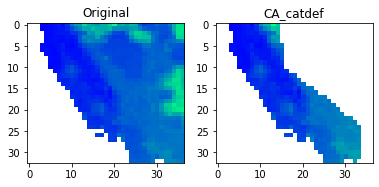

In [11]:
fig = plt.figure(figsize=(40,4))

plt.subplot(1,12,1)
plt.title('Original')
plt.imshow(all_data_df['catdef'][0].reshape(33,37), cmap = 'winter')

plt.subplot(1,12,2)
plt.title('CA_catdef')
plt.imshow(all_data_df['CA_catdef'][0].reshape(33,37), cmap = 'winter')

# for i in range(3,13):
#     msk_rg = 'catdef_region_' + str(i-2)
#     plt.subplot(1,12,i)
#     plt.title('Masked' + str(i-2))
#     plt.imshow(all_data_df[msk_rg][0], cmap = 'winter')

In [12]:
region_sizes = []
for i in range(1,11):
    matches = region_mask[region_mask == i]
    region_sizes.append(len(matches))
    print(i, ":",  len(matches))

1 : 52
2 : 11
3 : 30
4 : 25
5 : 76
6 : 46
7 : 36
8 : 21
9 : 81
10 : 62


## Functions 

In [13]:
def general_plot(plotlist, cmap = 'winter'):
    fig = plt.figure(figsize=(4,4))
    if len(plotlist) > 33:
        plotlist = np.array(plotlist).reshape(33,37)

    plt.imshow(plotlist, cmap = cmap)

In [14]:
def dual_plot(pred, actual):
    if len(pred) > 33:
        pred = np.array(pred).reshape(33,37)
    if len(actual) > 33:
        actual = np.array(actual).reshape(33,37)
    
    fig = plt.figure(figsize=(4,4))
    plt.subplot(1,2,1)
    plt.title('pred')
    plt.imshow(pred, cmap = 'winter')
    
    plt.subplot(1,2,2)
    plt.title('actual')
    plt.imshow(actual, cmap = 'winter')

In [14]:
# # this applies the region mask to a flat list
# def mask_list(full_list, region):
#     if len(full_list) == 1:
#         full_list = full_list[0]
#     masked_list = np.array(full_list.copy())
#     for i in range(len(full_list)):
#         if region == 9999:
#             if flat_mask[i] > 0:
#                  masked_list[i] = full_list[i]
#             else:
#                 masked_list[i] = None
#         else:        
#             if flat_mask[i] == region:
#                 masked_list[i] = full_list[i]
#             else:
#                 masked_list[i] = None 
#     return masked_list

In [15]:
# this creates a new df by sampling portions of several y predictions (from separate models) into a single 1221-length list
# intended for use with the loaded .pkl file of predictions
model_region_dict = {
    1:'model_1_rzmc',
    2:'model_2_srfexc',
    3:'model_3_srfexc',
    4:'base_model_srfexc',
    5:'model_5_rzmc',
    6:'model_6_srfexc',
    7:'model_7_srfexc',
    8:'base_model_srfexc',
    9:'base_model_srfexc',
    10:'model_10_srfexc'     
}
def sampler(reference_df, region_dict, month):
    df = reference_df.copy(deep=True)
    new_array = []
    for j in range(len(flat_mask)):
        if flat_mask[j] in model_region_dict.keys():
            new_array.append(loaded_predictions['y_prediction'][(loaded_predictions['Month'] == month) & (loaded_predictions['Model'] == model_region_dict.get(flat_mask[j]))].tolist()[0][j])
            # array[j] = df['y_prediction'][(df['Month'] == month) & (df['Model'] == 'model_1')][0][j]

        else: new_array.append(0)

    return new_array    
    
# z = sampler(loaded_predictions, model_region_dict, 140)  
    
  

In [16]:
# this applies the region mask to a 33x37 array
def mask_image(image, region):
        masked_frame = image.copy()
        for i in range(len(masked_frame)):
            for j in range(len(masked_frame[i])):
                if pd.notna(masked_frame[i][j]) and region_mask[i][j] != region:
                    masked_frame[i][j] = None
        return masked_frame
    

In [17]:
#this cycles through selected models over selected months and collects the full prediction (y) for each combination
def get_predictions(df0, model, months_array):   
    df = df0,copy()
    all_predictions = []
    pred_base_df = pd.DataFrame()
    pred_base_df['Month'] = months_array
    pred_base_df['Model'] = model.name
    
    for month in months_array:
        if multi_features == 0:
            test_img = np.nan_to_num(np.array(df['Color_SCA_Image'][month].resize(1, 128,128, 4)), nan=0)
            y_pred = model.predict(test_img.reshape(1, 128,128, 4))
        if multi_features == 1:
            y_pred = model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
        all_predictions.append(y_pred[0])
    pred_base_df['y_prediction'] = all_predictions
    
    return pred_base_df

In [18]:
#this cycles through selected models over selected months and collects the full prediction (y) for each combination
def get_predictions_mult(X_test, model, months_array):   
    all_predictions = []
    pred_base_df = pd.DataFrame()
    pred_base_df['Month'] = months_array
    pred_base_df['Model'] = model.name
    
    for month in range(len(X_test)):
        if multi_features == 0:
            test_img = np.nan_to_num(np.array(df['Color_SCA_Image'][month].resize(1, 128,128, 4)), nan=0)
            y_pred = model.predict(test_img.reshape(1, 128,128, 4))
        if multi_features == 1:
            y_pred = model.predict(X_test[month].reshape(1, 1, 152, 324, 4))
        all_predictions.append(y_pred[0])
    pred_base_df['y_prediction'] = all_predictions
    
    return pred_base_df

In [19]:
def quick_eval(pred, true):
    true = np.nan_to_num(true, nan=0)
    pred = np.nan_to_num(pred, nan=0)
    accuracy =   1 - abs(np.sum(pred)-np.sum(true))/np.sum(true)
    print(accuracy)
    return accuracy

In [20]:
def conv_snowcap_img(idx, height, width):
    #img = (255 - np.nan_to_num(np.array(all_data_df['Color_SCA_Image'][idx].resize((height, width))), nan=0))
    img = np.nan_to_num(np.array(all_data_df['Color_SCA_Image'][idx].resize((height, width))), nan=0)
    for ix in range(height):
        for iy in range(width):
            img[ix][iy][3] = 255
    #if lighten != 1:
    # img = lighten_img(img, height, width, lighten)
    
    return img

In [21]:
def get_img_arr2(data, snowcap):
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(data, interpolation='nearest')

    plt.subplot(1,2,2)
    plt.axis('off')    
    plt.imshow(snowcap)
    with io.BytesIO() as buffer:
        plt.savefig(buffer, format = "png")            
        image = Image.open(buffer)        
        cropped_image = image.crop(image.getbbox())                
        ar = np.asarray(cropped_image)
    plt.cla()
    plt.clf()
    return ar

## Model setup 

In [22]:
IMAGE_SHAPE = (1, 152,324, 4)
    

# model = keras.models.load_model(save_str_model)

def setup(name):
    model = Sequential()
    full_name = str(name + '_' + str(second_feature))
    model._name = full_name
    model.add(ConvLSTM2D(64, kernel_size=(3,3), input_shape=IMAGE_SHAPE, padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(ConvLSTM2D(64, kernel_size=(3,3), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1,2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(1300))
    model.add(Dense(1300))
    model.add(Dropout(0.1))
    model.add(Dense(1221, activation=tf.keras.activations.linear))
    return(model)

# model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

## Set X test and train for rzmc

CPU times: user 19.5 s, sys: 14.8 ms, total: 19.5 s
Wall time: 19.5 s


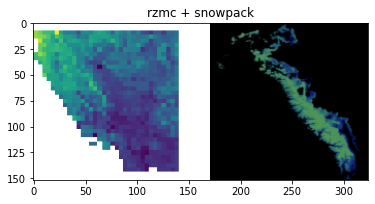

In [23]:
%%time
second_feature = 'rzmc'
# Make training dataset
X_data_rzmc = np.reshape(np.array(all_data_df[second_feature][:train_size]), (train_size, 1))
for ix,iy in np.ndindex(X_data_rzmc.shape):  
    X_data_rzmc[ix,iy] = get_img_arr2(X_data_rzmc[ix,iy], conv_snowcap_img(ix, 256, 256))

    
X_train_rzmc = np.array(X_data_rzmc.tolist())
X_train_rzmc.shape
plt.title(str(str(second_feature) + ' + snowpack'))
plt.imshow(X_train_rzmc[122][0])        


(152, 324, 4)

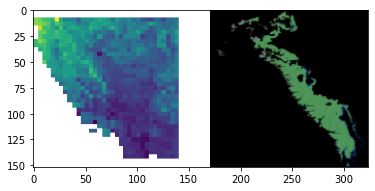

In [24]:
# Make test dataset


X_test_data_rzmc = np.reshape(np.array(all_data_df[second_feature][train_size:]), (all_data_df.shape[0] - train_size, 1))
for ix,iy in np.ndindex(X_test_data_rzmc.shape):
    #X_data[ix,iy] = tf.image.resize(X_data[ix,iy], [img_height, img_width])
    X_test_data_rzmc[ix,iy] = get_img_arr2(X_test_data_rzmc[ix,iy], 
                        conv_snowcap_img((train_size) + ix, 256, 256))

X_test_rzmc = np.array(X_test_data_rzmc.tolist())
plt.imshow(X_test_rzmc[0][0])
np.shape(X_test_rzmc[0][0])

## Set X test and train for srfexc

CPU times: user 19.3 s, sys: 26.5 ms, total: 19.3 s
Wall time: 19.3 s


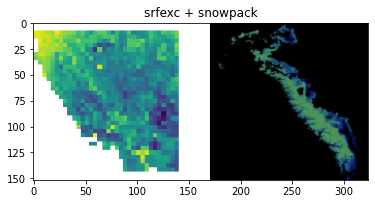

In [25]:
%%time

second_feature = 'srfexc'
# Make training dataset
X_data_srfexc = np.reshape(np.array(all_data_df[second_feature][:train_size]), (train_size, 1))
for ix,iy in np.ndindex(X_data_srfexc.shape):  
    X_data_srfexc[ix,iy] = get_img_arr2(X_data_srfexc[ix,iy], conv_snowcap_img(ix, 256, 256))

    
X_train_srfexc = np.array(X_data_srfexc.tolist())
X_train_srfexc.shape
plt.title(str(str(second_feature) + ' + snowpack'))
plt.imshow(X_train_srfexc[122][0])        

(152, 324, 4)

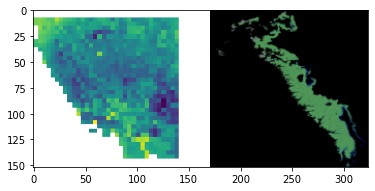

In [27]:
# Make test dataset

X_test_data_srfexc = np.reshape(np.array(all_data_df[second_feature][train_size:]), (all_data_df.shape[0] - train_size, 1))
for ix,iy in np.ndindex(X_test_data_srfexc.shape):
    #X_data[ix,iy] = tf.image.resize(X_data[ix,iy], [img_height, img_width])
    X_test_data_srfexc[ix,iy] = get_img_arr2(X_test_data_srfexc[ix,iy], 
                        conv_snowcap_img((train_size) + ix, 256, 256))

X_test_srfexc = np.array(X_test_data_srfexc.tolist())
plt.imshow(X_test_srfexc[0][0])
np.shape(X_test_srfexc[0][0])

## Train regional models with various features based on evaluation notebook

Notes:
The reason for deleting each model from the runtime before training the next is to prevent exhausting memory. We often had to reset the runtime between models anyway, thus the strategy of saving each model, then reloading them one by one to compile the predictions.


In [27]:
%%time

# Train base model with srfexc and full CA catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc

Y_train = all_data_df['catdef'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
base_model = setup('base_model')
base_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = base_model.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = base_model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_base = quick_eval(mask_list(pred[0],9999), all_data_df['CA_catdef'][train_size])

clear_output(wait=True)
print(quick_perf_base)

In [28]:
# check base model against region 4
pred = base_model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_base = quick_eval(mask_list(pred[0],4), all_data_df['catdef_region_4'][train_size])

In [29]:
check base model against region 8
pred = base_model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_base = quick_eval(mask_list(pred[0],8), all_data_df['catdef_region_8'][train_size])

In [30]:
# check base model against region 9
pred = base_model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_base = quick_eval(mask_list(pred[0],9), all_data_df['catdef_region_9'][train_size])

In [31]:
if save_models == 1:
    model_savestr = str('base_model_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    base_model.save(model_savestr)  

del base_model

tf.keras.backend.clear_session()
clear_output(wait=True)

In [208]:
%%time

# Train model 1  with rzmc and region 1 catdef

second_feature = 'rzmc'
X_train = X_train_rzmc
X_test = X_test_rzmc

Y_train = all_data_df['catdef_region_1'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_1 = setup('model_1')
model_1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_1.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_1.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_1 = quick_eval(mask_list(pred[0],1), all_data_df['catdef_region_1'][train_size])


if save_models == 1:
    model_savestr = str('model_1_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_1.save(model_savestr)  

del model_1
tf.keras.backend.clear_session()
clear_output()
print(quick_perf_1)

0.8711601281155837
CPU times: user 5min 32s, sys: 1min 38s, total: 7min 10s
Wall time: 8min 45s


In [33]:
%%time

# Train model 2  with rzmc and region 2 catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc


Y_train = all_data_df['catdef_region_2'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_2 = setup('model_2')
model_2.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_2.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_2.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_2 = quick_eval(mask_list(pred[0],2), all_data_df['catdef_region_2'][train_size])


if save_models == 1:
    model_savestr = str('model_2_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_2.save(model_savestr)  


del model_2
tf.keras.backend.clear_session()
clear_output(wait=True)
print(quick_perf_2)

0.9642117010494011
CPU times: user 5min 41s, sys: 1min 39s, total: 7min 21s
Wall time: 8min 52s


In [34]:
%%time

# Train model 3  with rzmc and region 3 catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc

Y_train = all_data_df['catdef_region_3'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_3 = setup('model_3')
model_3.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_3.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_3.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_3 = quick_eval(mask_list(pred[0],3), all_data_df['catdef_region_3'][train_size])

if save_models == 1:
    model_savestr = str('model_3_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_3.save(model_savestr)  

del model_3

tf.keras.backend.clear_session()
clear_output(wait=True)
print(quick_perf_3)

0.9251299916964619
CPU times: user 5min 36s, sys: 1min 38s, total: 7min 15s
Wall time: 8min 47s


In [35]:
## Model 4 uses the srfexc base model

In [36]:
%%time

# Train model 5 with rzmc and region 5 catdef

second_feature = 'rzmc'
X_train = X_train_rzmc
X_test = X_test_rzmc



Y_train = all_data_df['catdef_region_5'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_5 = setup('model_5')
model_5.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_5.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_5.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_5 = quick_eval(mask_list(pred[0],5), all_data_df['catdef_region_5'][train_size])


if save_models == 1:
    model_savestr = str('model_5_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_5.save(model_savestr)  

del model_5
tf.keras.backend.clear_session()

clear_output(wait=True)
print(quick_perf_5)

0.9114528655067738
CPU times: user 5min 37s, sys: 1min 39s, total: 7min 16s
Wall time: 8min 47s


'/home/jupyter/CA-Hydrology-W210-SP2022'

In [ ]:
%%time

# Train model 6  with rzmc and region 6 catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc


Y_train = all_data_df['catdef_region_6'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_6 = setup('model_6')
model_6.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_6.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_6.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_6 = quick_eval(mask_list(pred[0],6), all_data_df['catdef_region_6'][train_size])


if save_models == 1:
    model_savestr = str('model_6_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_6.save(model_savestr)  

del model_6
tf.keras.backend.clear_session()
clear_output(wait=True)
print(quick_perf_6)

In [38]:
%%time

# Train model 7  with rzmc and region 7 catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc


Y_train = all_data_df['catdef_region_7'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_7 = setup('model_7')
model_7.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_7.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_7.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_7 = quick_eval(mask_list(pred[0],7), all_data_df['catdef_region_7'][train_size])


if save_models == 1:
    model_savestr = str('model_7_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_7.save(model_savestr)  

del model_7
tf.keras.backend.clear_session()
clear_output(wait=True)
print(quick_perf_7)

0.9052858041212035
CPU times: user 5min 36s, sys: 1min 38s, total: 7min 15s
Wall time: 8min 47s


In [39]:
%%time

# Train model 10  with rzmc and region 10 catdef

second_feature = 'srfexc'
X_train = X_train_srfexc
X_test = X_test_srfexc


Y_train = all_data_df['catdef_region_10'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
model_10 = setup('model_10')
model_10.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model_10.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)

pred = model_10.predict(X_test[0].reshape(1, 1, 152, 324, 4))
quick_perf_10 = quick_eval(mask_list(pred[0],10), all_data_df['catdef_region_10'][train_size])


if save_models == 1:
    model_savestr = str('model_10_' + str(second_feature))
    model_savestr = str('clstm_models/' + model_savestr)
    model_10.save(model_savestr)  

del model_10
tf.keras.backend.clear_session()
clear_output(wait=True)
print(quick_perf_10)

0.9312006364045589
CPU times: user 5min 38s, sys: 1min 38s, total: 7min 16s
Wall time: 8min 46s


# Compile prediction

In [40]:
 # model = tf.keras.models.load_model('2_input_models/original_model')

In [32]:
%%time

####  Concat prediction sets from all models into a single df
# compile_predictions = 1

model_names = ['model_1_rzmc', 'model_2_srfexc', 'model_3_srfexc', 'base_model_srfexc', 'model_5_rzmc', 'model_6_srfexc', 'model_7_srfexc', 'base_model_srfexc', 'base_model_srfexc', 'model_10_srfexc']

    
if compile_predictions == 1:
    model_path = 'clstm_models/'

    start_predictions = pd.DataFrame()

    for i in tqdm(model_names):
        feature = i.split('_')[-1]
        if feature == 'rzmc':
            X_test = X_test_rzmc
        if feature == 'srfexc':
            X_test = X_test_srfexc        
        
        model_temp = pd.Series()
        model_temp.rename(str('model_temp_' + str(i)))
        load_model = str(model_path + i)
        model = tf.keras.models.load_model(load_model)
        if start_predictions.empty:
            start_predictions = get_predictions_mult(X_test, model, test_months)
        else: 
            add_predictions = get_predictions_mult(X_test, model, test_months)
            all_the_predictions = pd.concat([start_predictions, add_predictions], ignore_index=True)
            start_predictions = all_the_predictions
        del model
        tf.keras.backend.clear_session()
    clear_output()
    all_the_predictions
#     # # fig = plt.figure(figsize=(40,4))
#     # # plt.subplot(1,12,1)
#     # # plt.imshow(pred_base_model[26].reshape(33,37), cmap = 'winter')

CPU times: user 12min 29s, sys: 8min 27s, total: 20min 56s
Wall time: 5min 38s


In [42]:
all_the_predictions

,Month,Model,y_prediction
0,123,model_1_rzmc,"[0.0654264, -0.1171373, -0.062752254, 22.3304,..."
1,124,model_1_rzmc,"[0.018641897, -0.08144672, -0.07982075, -2.512..."
2,125,model_1_rzmc,"[-0.053258486, -0.002386252, -0.062345345, -2...."
3,126,model_1_rzmc,"[-0.045807235, -0.053811785, -0.03968834, 73.6..."
4,127,model_1_rzmc,"[-0.03227909, -0.025669577, -0.038344305, 23.3..."
...,...,...,...
445,163,model_10_srfexc,"[0.055393673, 0.39257914, 0.6837131, 0.2874054..."
446,164,model_10_srfexc,"[0.058880545, 0.439519, 0.731727, 0.316535, 0...."
447,165,model_10_srfexc,"[0.07664309, 0.3721773, 0.73747665, 0.39406633..."
448,166,model_10_srfexc,"[0.07890246, 0.3409248, 0.7009239, 0.29939973,..."


In [43]:
# plt.imshow(all_the_predictions[][0].reshape(33,37))

# Load/save predictions

In [34]:
#### save compiled pred to .pkl

# compile_predictions = 1
if compile_predictions == 1:
    pred_savestr = str('best_models_predictions.pkl')
    path = str('CLSTM_temp/' + pred_savestr)
    with open(path, "wb") as fh:
      pickle.dump(all_the_predictions, fh)

In [37]:
###### Reload saved predictions (.pkl file)
compile_predictions = 1

if compile_predictions == 1:
    pred_savestr = str('best_models_predictions.pkl')
    path = str('CLSTM_temp/' + pred_savestr)
    with open(path, "rb") as fh:
      loaded_predictions = pickle.load(fh)
    loaded_predictions.head(5)

In [38]:
loaded_predictions.head(5)

,Month,Model,y_prediction
0,123,model_1_rzmc,"[-0.12484738, -0.20079178, -0.2944385, 72.0396..."
1,124,model_1_rzmc,"[-0.22707625, -0.21239012, -0.317091, 126.8214..."
2,125,model_1_rzmc,"[-0.2529137, -0.2156142, -0.31104067, 139.1792..."
3,126,model_1_rzmc,"[-0.20974173, -0.04727655, -0.59075093, 204.55..."
4,127,model_1_rzmc,"[-0.20904186, 0.036027826, -0.608127, 240.3925..."


# Combine model outputs into statewide catdef prediction

In [39]:
mix_df = loaded_predictions.copy()

# mix_df['region_key'] = list(range(1,11))*45
mix_df['y_masked'] = abs(mix_df['y_prediction'] * 0)

for i in range(len(mix_df['Month'])):
    c = int(i / len(mix_df['Month'].unique()))
    mix_df['Model'][i] = str( mix_df['Model'][i] + '__' + str(c + 1))
    
for i in range(len(mix_df['Month'])):
    region_key = mix_df['Model'][i].split('__')[1]
    mix_df['y_masked'][i] = mask_list(mix_df['y_prediction'][i], int(region_key))
    
mix_df

,Month,Model,y_prediction,y_masked
0,123,model_1_rzmc__1,"[-0.12484738, -0.20079178, -0.2944385, 72.0396...","[nan, nan, nan, 72.03965, 90.39742, 99.01827, ..."
1,124,model_1_rzmc__1,"[-0.22707625, -0.21239012, -0.317091, 126.8214...","[nan, nan, nan, 126.82143, 150.81822, 157.4626..."
2,125,model_1_rzmc__1,"[-0.2529137, -0.2156142, -0.31104067, 139.1792...","[nan, nan, nan, 139.1792, 174.16031, 184.26869..."
3,126,model_1_rzmc__1,"[-0.20974173, -0.04727655, -0.59075093, 204.55...","[nan, nan, nan, 204.55258, 250.36441, 260.1317..."
4,127,model_1_rzmc__1,"[-0.20904186, 0.036027826, -0.608127, 240.3925...","[nan, nan, nan, 240.39258, 289.5045, 296.64984..."
...,...,...,...,...
445,163,model_10_srfexc__10,"[0.055393077, 0.39257973, 0.6837145, 0.2874048...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
446,164,model_10_srfexc__10,"[0.058880083, 0.43951938, 0.7317276, 0.3165344...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
447,165,model_10_srfexc__10,"[0.07664209, 0.37217745, 0.73747593, 0.3940663...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
448,166,model_10_srfexc__10,"[0.0789023, 0.3409247, 0.7009238, 0.2994001, 0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [48]:
# plt.imshow(mix_df['y_masked'][200].reshape(33,37))

In [40]:
combined_predictions = pd.DataFrame()
combined_predictions['Month'] =  mix_df['Month'].unique()
pred_list = []

for month in mix_df['Month'].unique():
    temp_df = []
    temp_df = mix_df[mix_df['Month'] == month].copy().reset_index(drop=True)
    
    
    combined_array = temp_df['y_masked'][0].copy()
    for i in range(len(temp_df['y_masked'])):
        for j in range(len(temp_df['y_masked'][i])):
            if temp_df['y_masked'][i][j] == temp_df['y_masked'][i][j]:
                combined_array[j] = temp_df['y_masked'][i][j]
    pred_list.append(combined_array)
    

In [41]:
combined_predictions['predicted_catdef'] = pred_list
combined_predictions.head()

,Month,predicted_catdef
0,123,"[nan, nan, nan, 72.03965, 90.39742, 99.01827, ..."
1,124,"[nan, nan, nan, 126.82143, 150.81822, 157.4626..."
2,125,"[nan, nan, nan, 139.1792, 174.16031, 184.26869..."
3,126,"[nan, nan, nan, 204.55258, 250.36441, 260.1317..."
4,127,"[nan, nan, nan, 240.39258, 289.5045, 296.64984..."


## Test statewide output vs actual catdef for accuracy

In [42]:
prediction_test = combined_predictions.copy()
prediction_test['Statewide_sum'] = prediction_test['predicted_catdef'].apply(lambda x: np.nansum(x))
prediction_test['Actual_catdef'] =  all_data_df['CA_catdef'][123:168].apply(lambda x: np.nansum(x)).reset_index(drop = True)
prediction_test['Accuracy'] = 1 - (abs(prediction_test['Statewide_sum'] - prediction_test['Actual_catdef']) / prediction_test['Actual_catdef'])
prediction_test.head()

,Month,predicted_catdef,Statewide_sum,Actual_catdef,Accuracy
0,123,"[nan, nan, nan, 72.03965, 90.39742, 99.01827, ...",143958.531250,156246.486,0.921355
1,124,"[nan, nan, nan, 126.82143, 150.81822, 157.4626...",159341.218750,169087.270,0.942361
2,125,"[nan, nan, nan, 139.1792, 174.16031, 184.26869...",166737.500000,180309.790,0.924728
3,126,"[nan, nan, nan, 204.55258, 250.36441, 260.1317...",164783.656250,187904.690,0.876953
4,127,"[nan, nan, nan, 240.39258, 289.5045, 296.64984...",178087.953125,191905.740,0.927997


In [43]:
print('Accuracy = ', str(np.average(prediction_test['Accuracy']) * 100), '%')

Accuracy =  90.93120417648363 %


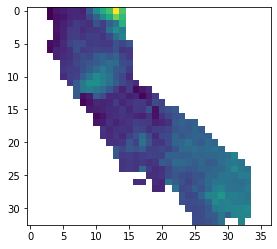

In [44]:
plt.imshow(prediction_test['predicted_catdef'][3].reshape(33,37))

## Export combined predictions for the ensemble model

In [46]:
  
path = '../Ensemble Modeling/convlstm_predictions.pkl'
with open(path, "wb") as fh:
    pickle.dump(combined_predictions, fh)

In [47]:
path = '../Ensemble Modeling/convlstm_predictions.pkl'
with open(path, "rb") as fh:
    loaded_output = pickle.load(fh)
loaded_output

,Month,predicted_catdef
0,123,"[nan, nan, nan, 72.03965, 90.39742, 99.01827, ..."
1,124,"[nan, nan, nan, 126.82143, 150.81822, 157.4626..."
2,125,"[nan, nan, nan, 139.1792, 174.16031, 184.26869..."
3,126,"[nan, nan, nan, 204.55258, 250.36441, 260.1317..."
4,127,"[nan, nan, nan, 240.39258, 289.5045, 296.64984..."
5,128,"[nan, nan, nan, 232.62494, 265.10406, 267.7397..."
6,129,"[nan, nan, nan, 193.40646, 227.02937, 235.5751..."
7,130,"[nan, nan, nan, 193.96019, 224.44371, 229.9181..."
8,131,"[nan, nan, nan, 138.39807, 172.77512, 182.3303..."
9,132,"[nan, nan, nan, 122.54395, 155.60283, 164.2646..."


********************